In [17]:
from utils import * 
from algorithms import *
from agents import *
import warnings 
warnings.filterwarnings('ignore')
import torch as th
th.autograd.set_detect_anomaly(True)
seed = 42
th.manual_seed(seed)
np.random.seed(seed)

In [18]:
def generateState(agent):
    counters = [agent.periodSteps, agent.stepTrades] #, agent.periodProfits, agent.stepTokenValue
    disclosureLength = len(agent.disclosure)
    if (disclosureLength == 0) | (agent.depth == 0):
        activityLog = []
    else:   
        if agent.gameSteps >= agent.depth:
            agent.disclosureCopy = deepcopy(agent.disclosure)
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                agent.disclosureCopy.remove('bids')
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                agent.disclosureCopy.remove('asks')
                asksDisclose = True
            
            activityLog = [[]]
            for i in range(1, agent.depth+1):
                activityLog[0] += agent.df.iloc[-i][agent.disclosureCopy].tolist()           
                if bidsDisclose:
                    activityLog[0] += agent.df.iloc[-i].bids
                if asksDisclose:
                    activityLog[0] += agent.df.iloc[-i].asks
            activityLog = activityLog[0]
        else:
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                disclosureLength -= 1
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                disclosureLength -= 1
                asksDisclose = True
            activityLog = [-1] * (disclosureLength*agent.depth + bidsDisclose*agent.depth*agent.numBuyers+asksDisclose*agent.depth*agent.numSellers)
        
    state = counters + activityLog
    cleanState = [-1 if np.isnan(x) else x for x in state]
    return cleanState

class Reinforcer(Trader):
    def __init__(self, gameData, disclosure=['currentBid', 'currentAsk', 'buy', 'sell', 'price', 'price'], 
                 index=0, buyer=1, reinforcer=1, numActions=10, algo='VPG', algoArgs=[], depth = 0, verbose = 0):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
        self.depth = depth
        self.disclosure = disclosure
        self.state = generateState(self)
        self.numStates = len(self.state)
        self.numActions = numActions
        self.state = [-1]*self.numStates
        self.algo = loadAlgo(algo, self.numStates, self.numActions, *algoArgs)
        self.done = False
        self.verbose = verbose
    
    def observe(self):
        self.newState = generateState(self)
        self.algo.observe(self.state, self.action, self.stepProfits, self.newState, self.done)
        if self.verbose == 1:
            print(self.state, self.action, self.stepProfits, self.newState, self.done)
        self.state = self.newState
        if (self.periodSteps == self.numSteps-1): # & (self.roundPeriods == self.numPeriods-1):
            self.done = True
        else:
            self.done = False

    def train(self):
        self.algo.train(self.state, self.action, self.stepProfits, self.newState, self.done)
        
    def bid(self):
        self.stepBid = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            self.stepBid = (self.action/(self.numActions-1)) * 100
        return self.stepBid
        
    def ask(self):
        self.stepAsk = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            self.stepAsk = (self.action/(self.numActions-1)) * 100
        return self.stepAsk

In [19]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

class PPO(nn.Module):
    def __init__(self):
        global num_states, verbose
        super(PPO, self).__init__()
        self.data = []
        self.fc_mu1   = nn.Linear(num_states,64)
        self.fc_mu2   = nn.Linear(64,32)
        self.fc_mu3   = nn.Linear(32,1) # mean action

        self.fc_std1  = nn.Linear(num_states,64)
        self.fc_std2  = nn.Linear(64,32)
        self.fc_std3  = nn.Linear(32,1) # std action

        self.fc_v1    = nn.Linear(num_states,128)
        self.fc_v2    = nn.Linear(128,64)       
        self.fc_v3    = nn.Linear(64,1) # value function
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.optimization_step = 0
        
        torch.nn.init.orthogonal_(self.fc_mu1.weight)
        torch.nn.init.orthogonal_(self.fc_mu2.weight)
        torch.nn.init.orthogonal_(self.fc_mu3.weight)
        torch.nn.init.orthogonal_(self.fc_std1.weight)
        torch.nn.init.orthogonal_(self.fc_std2.weight)
        torch.nn.init.orthogonal_(self.fc_std3.weight)
        torch.nn.init.orthogonal_(self.fc_v1.weight)
        torch.nn.init.orthogonal_(self.fc_v2.weight)
        torch.nn.init.orthogonal_(self.fc_v3.weight)
        
    def pi(self, x, softmax_dim = 0):
        mu  = F.leaky_relu(self.fc_mu1(x))
        mu  = F.leaky_relu(self.fc_mu2(mu))
        mu  = F.tanh(self.fc_mu3(mu))
        std = F.leaky_relu(self.fc_std1(x))
        std = F.leaky_relu(self.fc_std2(std))
        std = F.softplus(self.fc_std3(std)-eta)
        return mu, std
    
    def v(self, x):
        v = F.leaky_relu(self.fc_v1(x))
        v = F.leaky_relu(self.fc_v2(v))
        v = self.fc_v3(v)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        if verbose == 1:
            (s, a, r, s_prime, log_prob, done) = transition[0]
            print(f's:{s}, a:{a},r:{r},sp:{s_prime},lp:{log_prob}, done:{done}')
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                td_target = r + gamma * self.v(s_prime) * done_mask
                delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

    def train_net(self):
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch

                    mu, std = self.pi(s, softmax_dim=1)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target)

                    self.optimizer.zero_grad()
                    loss.mean().backward()
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                    self.optimizer.step()
                    self.optimization_step += 1
        

In [20]:
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces

class GymEnv(gym.Env):
    def __init__(self, metaData, buyers, sellers, log):
        self.gameData = metaData[0:8]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = self.gameData
        self.disclosure, self.buyers, self.sellers = metaData[8:]
        self.log = log
        self.rnd = 0
        self.period = 0
        self.Step = 0
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float32)
        self.numStates = len(generateState(self.buyers[0]))
        self.observation_space = spaces.Box(-1,9,(self.numStates,),dtype=np.float32)
        startRounds(self.gameData, self.log, self.buyers, self.sellers, self.rnd)
    
    def reset(self, seed = None):
        startPeriods(self.buyers, self.sellers)
        generateState(self.buyers[0])
        return self.buyers[0].state, {}

    def step(self, action):
        global verbose
        startSteps(self.buyers, self.sellers)
        bids, asks = collectOffers(self.buyers, self.sellers)
        min = buyers[0].stepTokenValue*0.01
        max = buyers[0].stepTokenValue*1.5
        trunc_action = nn.functional.tanh(torch.tensor(action))
        frac = (trunc_action.item()+1)/2
        #bids[0] = min * (1-(F.tanh(torch.tensor(action[0]))+1)/2) + (F.tanh(torch.tensor(action[0]))+1)/2 * max
        bids[0] = min * (1-frac) + frac * max
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
        bprofit, sprofit = 0, 0
        if price > 0:
            self.buyers[currentBidIdx].transact(price)
            self.sellers[currentAskIdx].transact(price)
            bprofit = self.buyers[currentBidIdx].stepProfits
            sprofit = self.sellers[currentAskIdx].stepProfits
        self.log.addStep([self.rnd, self.period, self.Step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(self.buyers, self.sellers, log.disclose())
        reward = 0.0
        if price > 0 and currentBidIdx == 0:
            reward = np.nan_to_num(bprofit,nan=0)
        if verbose == 1:
            print(f'bid:{bids[0]},reward:{reward}')
        updateStates(self.buyers, self.sellers)
        newState = self.buyers[0].state
        done = self.buyers[0].done
        updatePolicy(self.buyers, self.sellers)
        endSteps(self.buyers, self.sellers)
        self.Step += 1
        if done:
            endPeriods(self.buyers, self.sellers)
            self.period += 1
            self.Step = 0
        return newState, reward, done, False, {}

numRounds, numPeriods, numSteps = 1, 10000, 9
numBuyers, numSellers, numTokens = 3, 6, 4
gameTypes, seed = '1111', 42
disclosure = []
#disclosure = ['currentAsk', 'currentBid']
depth = 0
# ZeroIntelligence, TruthTeller

gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, depth = depth,algo='BASE'),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
]
sellers = [
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
          ]
log = Log(gameData, disclosure)
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed, disclosure, buyers, sellers]
env = GymEnv(metaData, buyers, sellers, log)
env.reset()
print(log.roundData.iloc[0].buyerValues)
print(log.roundData.iloc[0].sellerCosts)
print(buyers[0].state)

[[ 99.25003886  82.45671643  77.66026229  65.21989865]
 [100.          84.05672672  63.22103594  62.96150214]
 [ 78.67729377  60.07550004  59.31575489  58.17739974]]
[[11.47061757 16.75562681 39.29472894 54.31626246]
 [22.83601084 29.76199996 33.6351073  56.56277446]
 [22.02002285 45.1952035  52.5790546  78.76449945]
 [27.9216024  38.27685302 51.64216474 57.74193037]
 [36.9662783  38.72188629 43.40438254 87.08807828]
 [24.4482233  26.90662066 47.53168931 66.02949848]]
[-1, -1]


In [21]:
learning_rate  = 0.0003
gamma          = 0.9
lmbda          = 0.9
eps_clip       = 0.25
rollout_len    = 1
minibatch_size = 32
buffer_size    = 5
K_epoch        = 10
eta            = 0
n_episodes     = 10000
verbose        = 0
num_states = 2
model = PPO()

In [ ]:
score = 0.0
print_interval = 100
rollout = []

for n_epi in range(n_episodes):
    s, _ = env.reset()
    done = False
    count = 0
    a_list = []
    while count < 200 and not done:
        for t in range(rollout_len):
            mu, std = model.pi(torch.from_numpy(np.array(s)).float())
            std = torch.clamp(std, 0.05, 0.5)
            dist = Normal(mu, std)
            if verbose == 1:
                print('\nmu',mu.item(),'std',std.item())
            a = dist.sample()
            a = torch.tanh(a)
            log_prob = -0.5 * ((a - mu) / std)**2 - 0.5 * np.log(2 * np.pi) - torch.log(std)
            s_prime, r, done, truncated, info = env.step([a.item()])
            a_list.append(a.item())
            rollout.append((s, a, r, s_prime, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []
            s = s_prime
            score += r
            count += 1
    model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}, optmization step: {}, {:.3f}, {:.3f}, {:.3f}, {:.3f}".format(n_epi,
                                                                                          score/print_interval,
                                                                                          model.optimization_step,
                                                                                          mu.item(), std.item(), 
                                                                                          np.mean(a_list), np.std(a_list)
                                                                                         ))
        score = 0.0

# of episode :100, avg score : 96.2, optmization step: 0, 0.716, 0.290, 0.484, 0.309
# of episode :200, avg score : 96.5, optmization step: 0, 0.716, 0.290, 0.550, 0.217
# of episode :300, avg score : 95.1, optmization step: 0, 0.716, 0.290, 0.348, 0.270
# of episode :400, avg score : 96.2, optmization step: 0, 0.716, 0.290, 0.403, 0.206
# of episode :500, avg score : 95.8, optmization step: 0, 0.716, 0.290, 0.481, 0.175
# of episode :600, avg score : 97.2, optmization step: 0, 0.716, 0.290, 0.495, 0.178
# of episode :700, avg score : 96.3, optmization step: 0, 0.716, 0.290, 0.392, 0.307
# of episode :800, avg score : 95.8, optmization step: 0, 0.716, 0.290, 0.574, 0.292
# of episode :900, avg score : 95.7, optmization step: 0, 0.716, 0.290, 0.548, 0.237
# of episode :1000, avg score : 97.8, optmization step: 0, 0.716, 0.290, 0.530, 0.151
# of episode :1100, avg score : 94.7, optmization step: 0, 0.716, 0.290, 0.584, 0.154
# of episode :1200, avg score : 93.9, optmization step: 0, 0.71

In [18]:
log.graphTraining(maxNumPeriods=100, skip = 20, trackBuyersIdx = [0])

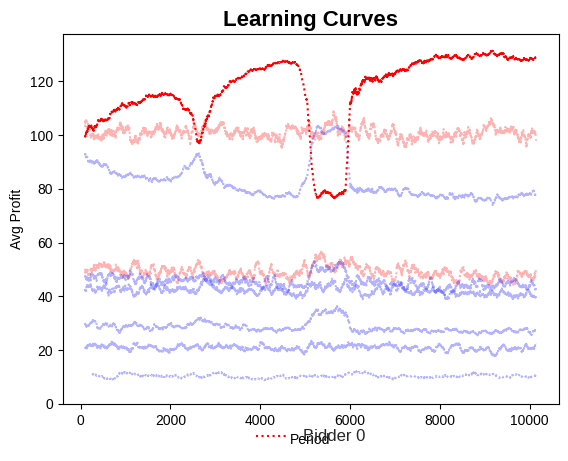

In [14]:
log.graphLearning(trackBuyersIdx = [0], trackSellersIdx = [], rolling_window=100, type = 'period')

In [ ]:
log.stepData.tail(10)

In [ ]:
log.graphSales(0, 4887, trackBuyersIdx=[0], trackSellersIdx=[])

In [ ]:
log.graphOffers(0, 4888, trackBuyersIdx=[0], trackSellersIdx=[])

In [130]:
class Log:
    def __init__(self, gameData,disclosure):
        self.gameData = gameData
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.stepData = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','currentBid','currentBidIdx','currentAsk',
                                             'currentAskIdx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.roundData = pd.DataFrame(columns=['rnd', 'buyerValues', 'sellerCosts', 'demand', 'supply', 'prices', 'peq', 'qeq', 
                                              'buyerReservationPrices', 'sellerReservationPrices', 'buyerSurplus', 'sellerSurplus', 
                                              'totalSurplus', 'buyerSurplusFrac', 'sellerSurplusFrac'])
        self.disclosure = disclosure
        
    def addStep(self, stepData):
        self.stepData.loc[len(self.stepData.index)] = stepData

    def addRound(self, roundData):
        self.roundData.loc[len(self.roundData.index)] = roundData
    
    def disclose(self):
        return self.stepData[self.disclosure].iloc[-1]
        
    def getPeriod(self, rnd, period):
        return self.stepData[(self.stepData.rnd==rnd) & (self.stepData.period==period)]
        
    def getPeriodActivity(self, rnd, period):
        periodData = self.getPeriod(rnd, period)
        periodBids = list(periodData.bids)
        periodAsks = list(periodData.asks)
        periodPrices = list(periodData.price)
        periodSales = np.cumsum(np.where(periodData.price > 0,1,0))
        return np.array(periodBids), np.array(periodAsks), np.array(periodPrices), np.array(periodSales)

    def getRound(self, rnd):
        return self.roundData[(self.roundData.rnd==rnd)]

    def getRoundList(self, rnd):
        return self.getRound(rnd).values.tolist()[0][1:]


    def graphSales(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        colors = customGraphSettings()
        fig, ax = graphMarket(*self.gameData, *self.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='black', linestyle='dashdot', label='Actual Prices')
        
        for j in range(self.numBuyers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodBids[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackBuyersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'red')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'red', alpha = 0.2)
                
        for j in range(self.numSellers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodAsks[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackSellersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'blue')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'blue', alpha = 0.2)
                
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter([periodSales[i]] * len(periodBids[i]), periodBids[i], s=10, alpha=0.2, c='red')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.2, c='blue')
                
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        ax.set_title('Dynamic Double Auction - Transactions', fontsize=16, fontweight='bold')
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()
    

    def graphOffers(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        notTrackSellers = [i for i in range(self.numBuyers) if i not in trackSellersIdx]
        ax.plot(periodBids[:,notTrackBuyers], c='red', linestyle='dotted', alpha = 0.3)
        ax.plot(periodBids[:,trackBuyersIdx], c='red', linestyle='dotted', alpha = 1.0)
        ax.scatter(range(self.numSteps), np.max(periodBids, axis = 1), c='red', label='Winning Bids', alpha = 0.5)
        ax.plot(periodAsks[:,notTrackSellers], c='blue', linestyle='dotted', alpha = 0.3)
        ax.plot(periodAsks[:,trackSellersIdx], c='blue', linestyle='dotted', alpha = 1.0)
        ax.scatter(range(self.numSteps), np.min(periodAsks, axis = 1), c='blue', label='Winning Asks', alpha = 0.5)
        #ax.plot(periodBids, c='red', linestyle='dotted', label='Bids')
        #ax.plot(periodAsks, c='blue', linestyle='dotted', label='Asks')
        ax.plot(range(self.numSteps), periodPrices, c='black', label='Prices', linestyle='dashdot')
        #ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.xlabel('Price')
        plt.ylabel('Time Step')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, len(periodSales), 1))
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()


    def graphLearning(self, trackBuyersIdx = [], trackSellersIdx = [], rolling_window = 1, type = 'period'):
        df = self.stepData
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        for j in range(self.numBuyers):
            rolling_mean = df[df.currentBidIdx == j][[type, 'bprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackBuyersIdx:
                ax.plot(rolling_mean, color = 'red', alpha = 1.0, linestyle = 'dotted', label = f'Bidder {j}')
            else:
                ax.plot(rolling_mean, color = 'red', alpha = 0.3, linestyle = 'dotted')
                
        for j in range(self.numSellers):
            rolling_mean = df[df.currentAskIdx == j][[type, 'sprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackSellersIdx:
                ax.plot(rolling_mean, color = 'blue', alpha = 1.0, linestyle = 'dotted', label = f'Asker {j}')
            else:
                ax.plot(rolling_mean, color = 'blue', alpha = 0.3, linestyle = 'dotted')
        
        ax.set_title('Learning Curves', fontsize=16, fontweight='bold')
        plt.xlabel('Period')
        plt.ylabel('Avg Profit')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        #ax.set_yticks(np.arange(0, 100, 5))
        #ax.set_xticks(np.arange(0, 100, 20))
        #ax.text(0.80, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        #ax.text(0.80, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.ylim(ymin=0)
        plt.show()

    def init(self, ax, totalProfit, period):
        ax.clear()
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.set_xlabel('Price')
        ax.set_ylabel('Time Step')
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 100)
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, 10, 1))
        ax.text(0.70, 0.10, f'Period: {period}', transform=ax.transAxes, alpha=0.5)
        ax.text(0.70, 0.05, f'Profit: {np.round(totalProfit, 1)}', transform=ax.transAxes, alpha=0.5)

    def update(self, ax, period, periodBids, periodAsks, trackBuyersIdx, trackSellersIdx):
        df = self.getPeriod(0, period)    
        try:
            totalProfit = df[df.currentBidIdx == 0].groupby('currentBidIdx').sum().bprofit.item()
        except:
            totalProfit = 0
        self.init(ax, totalProfit, period)

        notTrackSellers = [i for i in range(self.numSellers) if i not in trackSellersIdx]
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        ax.plot(np.array(periodBids)[:, notTrackBuyers], c='red', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodBids)[:, trackBuyersIdx], c='red', linestyle='dotted', alpha=1.0)
        ax.plot(np.array(periodAsks)[:, notTrackSellers], c='blue', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodAsks)[:, trackSellersIdx], c='blue', linestyle='dotted', alpha=1.0)

        a = np.max(np.array(periodBids), axis=0)
        b = np.max(np.array(periodBids)[:, trackBuyersIdx], axis=0)
        timesteps, maxbids = [], []
        for i in range(np.array(periodBids).shape[0]):
            if a[i] == b[i]:
                timesteps.append(i)
                maxbids.append(a[i])
        
        ax.scatter(timesteps, maxbids, c='green', marker='o', label='Winning Bid')   
        print(timesteps, maxbids)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Offers')
        ax.legend()

    def clean_frames_folder(self):
        for filename in os.listdir('frames'):
            file_path = os.path.join('frames', filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
        if os.path.exists('frames'):
            os.rmdir('frames')

    def graphTraining(self, rnd=0, skip=1, maxNumPeriods=1000, trackBuyersIdx=[0], trackSellersIdx=[]):
        fig, ax = plt.subplots()

        if not os.path.exists('frames'):
            os.makedirs('frames')

        for period in range(1, maxNumPeriods, skip):
            periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd, period)
            self.update(ax, period, periodBids, periodAsks, trackBuyersIdx, trackSellersIdx)
            plt.savefig(f'frames/period_{period}_frame.png')

        plt.close(fig)

        if os.path.exists('animation.gif'):
            os.remove('animation.gif')

        images = []
        for period in range(1, maxNumPeriods, skip):
            filename = f'frames/period_{period}_frame.png'
            images.append(imageio.imread(filename))
        imageio.mimsave('animation.gif', images)
        self.clean_frames_folder()

In [111]:
def update(self, ax, period, periodBids, periodAsks, trackBuyersIdx, trackSellersIdx):
        df = self.getPeriod(0, period)
        try:
            totalProfit = df[df.currentBidIdx == 0].groupby('currentBidIdx').sum().bprofit.item()
        except:
            totalProfit = 0
        self.init(ax, totalProfit, period)
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        notTrackSellers = [i for i in range(self.numBuyers) if i not in trackSellersIdx]
        ax.plot(np.array(periodBids)[:, notTrackBuyers], c='red', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodBids)[:, trackBuyersIdx], c='red', linestyle='dotted', alpha=1.0)
        ax.plot(np.array(periodAsks)[:, notTrackSellers], c='blue', linestyle='dotted', alpha=0.3)
        ax.plot(np.array(periodAsks)[:, trackSellersIdx], c='blue', linestyle='dotted', alpha=1.0)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Offer')